In [784]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, fbeta_score
from sklearn.svm import SVR, SVC
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn.metrics import make_scorer 

RSEED=42

import airportsdata

# Loading data + Info

|column|description|
|---|---|
|DATOP | Date of flight|
|FLTID | Flight number|
|DEPSTN | Departure point|
|ARRSTN | Arrival point|
|STD | Scheduled Time departure|
|STA | Scheduled Time arrival|
STATUS | Flight status|
|ETD | Expected Time departure|
|ETA | Expected Time arrival|
|ATD | Actual Time of Departure|
|ATA | Actual Time of arrival|
|DELAY1 | Delay code 1|
|DUR1 | delay time 1|
|DELAY2 | Delay code 2|
|DUR2 | delay time 2|
|DELAY3 | Delay code 3|
|DUR3 | delay time 3|
|DELAY4 | Delay code 4|
|DUR4 | delay time 4|
|AC | Aircraft Code|



In [785]:
df_train = pd.read_csv("data/Train.csv")
df_test = pd.read_csv("data/Test.csv")
SampleSubmission = pd.read_csv("data/SampleSubmission.csv")
airports= airportsdata.load()


In [786]:
#airports["KJFK"]["name"]

In [787]:
# loading airport data into separate df for EDA (otherwise too large), combining with 

air= pd.DataFrame(airports).T.reset_index()
air

load_data = pd.DataFrame(airportsdata.load('IATA'))
airport_data = load_data.T.reset_index()
df_new = df_train.merge(airport_data, how= 'left', left_on ='DEPSTN', right_on ='index').merge(airport_data, how= 'left', left_on='ARRSTN', right_on='index')
df_new.columns = df_new.columns.str.replace('_x', '_dep').str.replace('_y', '_arr')

In [788]:
df_new.shape

(107833, 32)

In [789]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107833 entries, 0 to 107832
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             107833 non-null  object 
 1   DATOP          107833 non-null  object 
 2   FLTID          107833 non-null  object 
 3   DEPSTN         107833 non-null  object 
 4   ARRSTN         107833 non-null  object 
 5   STD            107833 non-null  object 
 6   STA            107833 non-null  object 
 7   STATUS         107833 non-null  object 
 8   AC             107833 non-null  object 
 9   target         107833 non-null  float64
 10  index_dep      107501 non-null  object 
 11  icao_dep       107501 non-null  object 
 12  iata_dep       107501 non-null  object 
 13  name_dep       107501 non-null  object 
 14  city_dep       107501 non-null  object 
 15  subd_dep       107501 non-null  object 
 16  country_dep    107501 non-null  object 
 17  elevation_dep  107501 non-nul

In [790]:
print(df_train.shape, df_test.shape, SampleSubmission.shape, df_new.shape)

(107833, 10) (9333, 9) (9333, 2) (107833, 32)


In [791]:
df_new.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'index_dep', 'icao_dep', 'iata_dep', 'name_dep',
       'city_dep', 'subd_dep', 'country_dep', 'elevation_dep', 'lat_dep',
       'lon_dep', 'tz_dep', 'index_arr', 'icao_arr', 'iata_arr', 'name_arr',
       'city_arr', 'subd_arr', 'country_arr', 'elevation_arr', 'lat_arr',
       'lon_arr', 'tz_arr'],
      dtype='object')

In [792]:
df_train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [793]:
df_train.tail()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0
107832,train_id_107832,2018-11-13,UG 0002,TUN,DJE,2018-11-13 06:15:00,2018-11-13 07.05.00,SCH,TU CR9ISA,0.0


In [794]:
df_new.describe()

,target
count,107833.000000
mean,48.733013
std,117.135562
min,0.000000
25%,0.000000
50%,14.000000
75%,43.000000
max,3451.000000


In [795]:
print(df_new.head())

           ID       DATOP     FLTID DEPSTN ARRSTN                  STD  \
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00   
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   STA STATUS         AC  target  ... icao_arr iata_arr  \
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0  ...     DTTA      TUN   
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0  ...     DTTA      TUN   
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0  ...     LTFM      IST   
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0  ...     LFRS      NTE   
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0  ...     DAAG      ALG   

                               name_arr  city_arr          subd_arr  \
0  Tunis Carthage International A

# Data cleaning

In [796]:
# convert STD and STA into datetime objects
df_new["STD"]=df_new["STD"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_new["STA"]=df_new["STA"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H.%M.%S'))
#df_new.STD.iloc[1].day

In [797]:
df_new[["STA","STD"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107833 entries, 0 to 107832
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   STA     107833 non-null  datetime64[ns]
 1   STD     107833 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 2.5 MB


In [798]:
# create new column with duration

df_new["sch_duration"]=(df_new.STA - df_new.STD)/timedelta(minutes=1)
print(df_new[["STA","STD","sch_duration"]].info())
print(df_new[["STA","STD","sch_duration"]].head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107833 entries, 0 to 107832
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   STA           107833 non-null  datetime64[ns]
 1   STD           107833 non-null  datetime64[ns]
 2   sch_duration  107833 non-null  float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 3.3 MB
None
                  STA                 STD  sch_duration
0 2016-01-03 12:55:00 2016-01-03 10:30:00         145.0
1 2016-01-13 16:55:00 2016-01-13 15:05:00         110.0
2 2016-01-16 06:45:00 2016-01-16 04:10:00         155.0
3 2016-01-17 17:00:00 2016-01-17 14:10:00         170.0
4 2016-01-17 15:50:00 2016-01-17 14:30:00          80.0


In [799]:
# creating additional date columns

df_new['dep_date'] = df_new['STD'].apply(lambda x: datetime.strftime(x,'%m-%d'))
df_new['dep_time'] = df_new['STD'].apply(lambda x: datetime.strftime(x,'%H:%M:%S'))

df_new['arr_date'] = df_new['STA'].apply(lambda x: datetime.strftime(x,'%m-%d'))
df_new['arr_time'] = df_new['STA'].apply(lambda x: datetime.strftime(x,'%H:%M:%S'))


In [800]:
# remove values with errrorous 
print(df_new.shape)
df_new = df_new.query(' (not (arr_date < dep_date and dep_date != "12-31"))')
print(df_new.shape)


(107833, 37)
(107822, 37)


In [801]:
# remove flight durations that are too long
print(df_new.shape)
df_new = df_new.query('sch_duration <= 24*60')
df_new = df_new.query('target <= 24*60')
print(df_new.shape)

(107822, 37)
(107365, 37)


In [802]:
# crating integer columns out of datetime objects for usage in EDA and ML

df_new['year'] = df_new['STD'].apply(lambda x: x.year).apply(pd.to_numeric)
df_new['dep_hour'] = df_new['STD'].apply(lambda x: x.hour).apply(pd.to_numeric)
df_new['arr_hour'] = df_new['STA'].apply(lambda x: x.hour).apply(pd.to_numeric)
df_new['dep_month'] = df_new['STD'].apply(lambda x: x.month).apply(pd.to_numeric)
df_new['arr_month'] = df_new['STA'].apply(lambda x: x.month).apply(pd.to_numeric)
df_new['dep_day'] = df_new['STD'].apply(lambda x: datetime.strftime(x,'%d')).apply(pd.to_numeric)
df_new['arr_day'] = df_new['STA'].apply(lambda x: datetime.strftime(x,'%d')).apply(pd.to_numeric)

In [803]:
# drop old STA and STD columns

df_new.drop(["STD","STA"], axis=1, inplace=True)

In [804]:
# split string of AC (aircraft code) into airline and airplane number. Use only airline

df_new.AC = df_new.AC.apply(lambda x: x.split(sep=' ')[0])

In [805]:
# remove SFX airport rows

df_new = df_new.query('DEPSTN != "SXF" and ARRSTN != "SXF"')
df_new.drop(["index_dep","index_arr"], axis=1, inplace=True)
df_new.shape

(106709, 40)

In [806]:
df_new.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STATUS', 'AC', 'target',
       'icao_dep', 'iata_dep', 'name_dep', 'city_dep', 'subd_dep',
       'country_dep', 'elevation_dep', 'lat_dep', 'lon_dep', 'tz_dep',
       'icao_arr', 'iata_arr', 'name_arr', 'city_arr', 'subd_arr',
       'country_arr', 'elevation_arr', 'lat_arr', 'lon_arr', 'tz_arr',
       'sch_duration', 'dep_date', 'dep_time', 'arr_date', 'arr_time', 'year',
       'dep_hour', 'arr_hour', 'dep_month', 'arr_month', 'dep_day', 'arr_day'],
      dtype='object')

In [807]:
# convert columns to numeric

df_new[["elevation_arr","elevation_dep","lat_arr","lon_arr","lat_dep","lon_dep"]]=df_new[["elevation_arr","elevation_dep","lat_arr","lon_arr","lat_dep","lon_dep"]].apply(pd.to_numeric)
df_new.head(2)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STATUS,AC,target,icao_dep,iata_dep,...,dep_time,arr_date,arr_time,year,dep_hour,arr_hour,dep_month,arr_month,dep_day,arr_day
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,ATA,TU,260.0,GMMN,CMN,...,10:30:00,01-03,12:55:00,2016,10,12,1,1,3,3
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,ATA,TU,20.0,LIMC,MXP,...,15:05:00,01-13,16:55:00,2016,15,16,1,1,13,13


In [808]:
# creating new column with distances between arrival and departure airport

distances = pd.read_csv('data/distance.csv')
df_new = df_new.merge(distances, on='ID')
df_new.drop(["Unnamed: 0"], axis=1, inplace=True)

In [809]:
# further column drops
df_new.drop(["DATOP","icao_arr","iata_arr","icao_dep","iata_dep","name_dep","name_dep"], axis=1, inplace=True)
df_new.drop(["ID"], axis=1, inplace=True)
df_new.drop(["dep_date","dep_time","arr_date","arr_time"], axis=1, inplace=True)



In [810]:
# binning of duration and removing larger than 1d
df_new['dur_cat'] = pd.cut(df_new.sch_duration, bins=[0, 120, 240, 360, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440]).apply(lambda x: x.right)
df_new['dur_cat'] = df_new['dur_cat'].astype(int)

In [811]:
# creating new column encoding for delayed (delay longer than 20min) or not delayed (shorter than 20min)
print(df_new.shape)
df_new['is_delayed'] = df_new['target'].apply(lambda x: 1 if x > 20 else 0)
print(df_new.shape)

(106709, 31)
(106709, 32)


In [812]:

df_new.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 106709 entries, 0 to 106708
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FLTID          106709 non-null  object 
 1   DEPSTN         106709 non-null  object 
 2   ARRSTN         106709 non-null  object 
 3   STATUS         106709 non-null  object 
 4   AC             106709 non-null  object 
 5   target         106709 non-null  float64
 6   city_dep       106709 non-null  object 
 7   subd_dep       106709 non-null  object 
 8   country_dep    106709 non-null  object 
 9   elevation_dep  106709 non-null  float64
 10  lat_dep        106709 non-null  float64
 11  lon_dep        106709 non-null  float64
 12  tz_dep         106709 non-null  object 
 13  name_arr       106709 non-null  object 
 14  city_arr       106709 non-null  object 
 15  subd_arr       106709 non-null  object 
 16  country_arr    106709 non-null  object 
 17  elevation_arr  106709 non-nul

In [813]:
# creating new short data frame and use it for dummy encoding
df1 = df_new[['STATUS', 'AC', 'target', 'country_dep', 'country_arr', 'trav_dist', 'year', 'dep_month',  'dep_day' , 'dep_hour', 'arr_month', 'arr_day',  'arr_hour', 'dur_cat',"is_delayed"]]
print(df1.info())
print(df1.shape)
#print(df1.nunique())
#df1 = pd.get_dummies(data=df1, prefix='con', prefix_sep='_', drop_first=True )
df1a = pd.get_dummies(data=df1["STATUS"], prefix='stat', prefix_sep='_', drop_first=True )
df1b = pd.get_dummies(data=df1["AC"], prefix='ac', prefix_sep='_', drop_first=True )
df1c = pd.get_dummies(data=df1["country_dep"], prefix='cd', prefix_sep='_', drop_first=True )
df1d = pd.get_dummies(data=df1["country_arr"], prefix='ca', prefix_sep='_', drop_first=True )
df1=pd.concat([df1,df1a,df1b,df1c,df1d],axis=1)
df1.drop(["STATUS","AC","country_dep","country_arr"], axis=1, inplace=True)
df1.shape


<class 'pandas.core.frame.DataFrame'>
Int64Index: 106709 entries, 0 to 106708
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STATUS       106709 non-null  object 
 1   AC           106709 non-null  object 
 2   target       106709 non-null  float64
 3   country_dep  106709 non-null  object 
 4   country_arr  106709 non-null  object 
 5   trav_dist    106709 non-null  float64
 6   year         106709 non-null  int64  
 7   dep_month    106709 non-null  int64  
 8   dep_day      106709 non-null  int64  
 9   dep_hour     106709 non-null  int64  
 10  arr_month    106709 non-null  int64  
 11  arr_day      106709 non-null  int64  
 12  arr_hour     106709 non-null  int64  
 13  dur_cat      106709 non-null  int64  
 14  is_delayed   106709 non-null  int64  
dtypes: float64(2), int64(9), object(4)
memory usage: 13.0+ MB
None
(106709, 15)


(106709, 131)

<AxesSubplot:xlabel='trav_dist', ylabel='Count'>

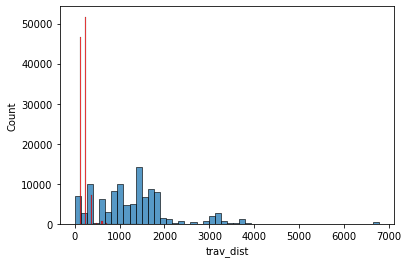

In [814]:
sns.histplot(data=df1, x="trav_dist",bins=50)
sns.histplot(data=df1, x="dur_cat",bins=50,color="red")

<AxesSubplot:xlabel='trav_dist', ylabel='Count'>

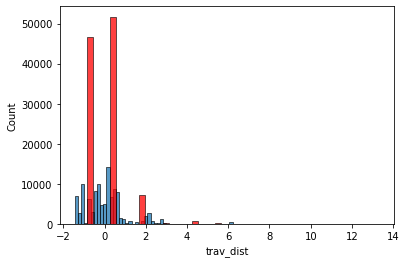

In [815]:
# scaling data columns trav_dist and dur_cat

#scaler = MinMaxScaler()
scaler = StandardScaler()
df1[['dur_cat', 'trav_dist']] = scaler.fit_transform(df1[['dur_cat', 'trav_dist']])
sns.histplot(data=df1, x="trav_dist",bins=50)
sns.histplot(data=df1, x="dur_cat",bins=50,color="red")

In [816]:
df1.describe()

,target,trav_dist,year,dep_month,dep_day,dep_hour,arr_month,arr_day,arr_hour,dur_cat,...,ca_SA,ca_SD,ca_SE,ca_SI,ca_SK,ca_SN,ca_TG,ca_TN,ca_TR,ca_UA
count,106709.000000,1.067090e+05,106709.000000,106709.000000,106709.000000,106709.000000,106709.000000,106709.000000,106709.000000,1.067090e+05,...,106709.000000,106709.000000,106709.000000,106709.00000,106709.000000,106709.000000,106709.000000,106709.000000,106709.000000,106709.000000
mean,46.965495,-9.801600e-17,2017.026446,6.678537,15.957960,12.116897,6.678921,15.954165,13.070331,-8.323369e-18,...,0.018040,0.000009,0.000187,0.00105,0.001106,0.006625,0.000009,0.568949,0.013748,0.000056
std,98.146900,1.000005e+00,0.813338,3.292975,8.884836,5.154097,3.292988,8.885740,5.347322,1.000005e+00,...,0.133096,0.003061,0.013689,0.03238,0.033236,0.081127,0.003061,0.495226,0.116442,0.007498
min,0.000000,-1.450197e+00,2016.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,-8.692600e-01,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-5.497860e-01,2016.000000,4.000000,8.000000,8.000000,4.000000,8.000000,9.000000,-8.692600e-01,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,-2.274226e-02,2017.000000,7.000000,16.000000,12.000000,7.000000,16.000000,13.000000,4.209073e-01,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,43.000000,4.307498e-01,2018.000000,9.000000,24.000000,16.000000,9.000000,24.000000,17.000000,4.209073e-01,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1427.000000,6.208340e+00,2018.000000,12.000000,31.000000,23.000000,12.000000,31.000000,23.000000,1.332258e+01,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [817]:
df1.head()

,target,trav_dist,year,dep_month,dep_day,dep_hour,arr_month,arr_day,arr_hour,dur_cat,...,ca_SA,ca_SD,ca_SE,ca_SI,ca_SK,ca_SN,ca_TG,ca_TN,ca_TR,ca_UA
0,260.0,0.430750,2016,1,3,10,1,3,12,0.420907,...,0,0,0,0,0,0,0,1,0,0
1,20.0,-0.340930,2016,1,13,15,1,13,16,-0.869260,...,0,0,0,0,0,0,0,1,0,0
2,0.0,0.437637,2016,1,16,4,1,16,6,0.420907,...,0,0,0,0,0,0,0,0,1,0
3,0.0,0.586644,2016,1,17,14,1,17,17,0.420907,...,0,0,0,0,0,0,0,0,0,0
4,22.0,-0.743710,2016,1,17,14,1,17,15,-0.869260,...,0,0,0,0,0,0,0,0,0,0


In [818]:
df1.shape

(106709, 131)

# Looking at data

<AxesSubplot:xlabel='target', ylabel='Count'>

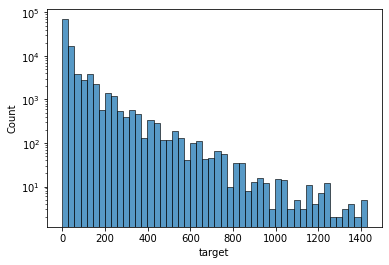

In [819]:
# Display distribution of target

#plt.ylim(0,2000)
#plt.xlim(0,500)
plt.semilogy(base=10)
sns.histplot(data=df1, x="target",bins=50)

<AxesSubplot:xlabel='trav_dist', ylabel='Count'>

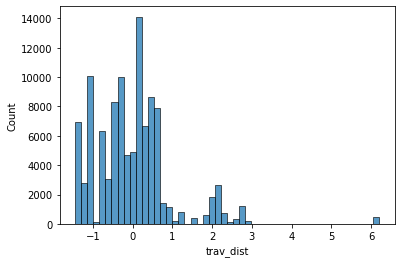

In [820]:
sns.histplot(data=df1, x="trav_dist",bins=50)

<AxesSubplot:xlabel='dur_cat', ylabel='Count'>

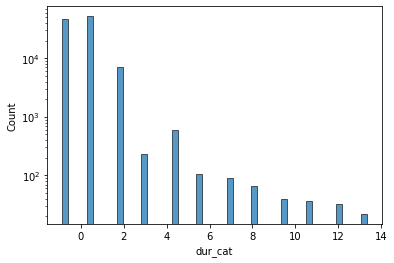

In [821]:
plt.yscale("log")
sns.histplot(data=df1, x="dur_cat",bins=50)

<AxesSubplot:xlabel='arr_hour', ylabel='count'>

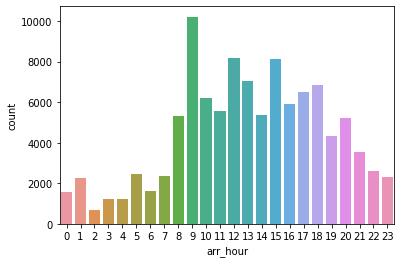

In [822]:
#plt.ylim(0,2000)
#plt.xlim(0,500)
#plt.semilogy(base=10)mont
sns.countplot(data=df1, x="arr_hour")

<AxesSubplot:xlabel='arr_month', ylabel='count'>

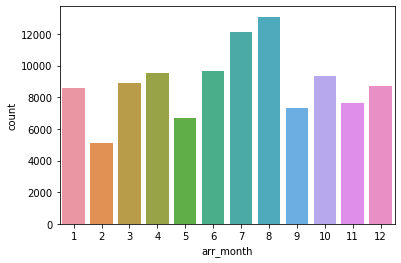

In [823]:
#plt.ylim(0,2000)
#plt.xlim(0,500)
#plt.semilogy(base=10)mont
sns.countplot(data=df1, x="arr_month")

<AxesSubplot:xlabel='year', ylabel='count'>

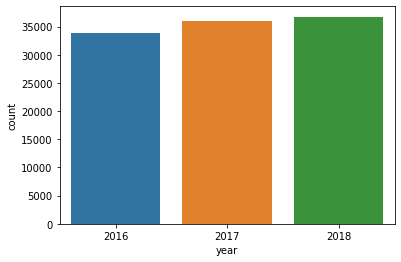

In [824]:
#plt.ylim(0,2000)
#plt.xlim(0,500)
#plt.semilogy(base=10)mont
sns.countplot(data=df1, x="year")

<AxesSubplot:xlabel='arr_hour', ylabel='count'>

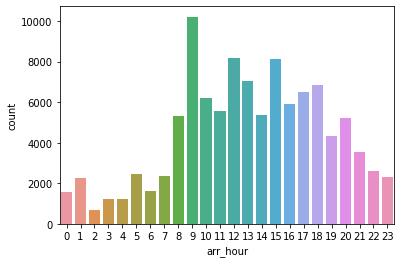

In [825]:
#plt.ylim(0,2000)
#plt.xlim(0,500)
#plt.semilogy(base=10)mont
sns.countplot(data=df1, x="arr_hour")

<AxesSubplot:xlabel='is_delayed', ylabel='count'>

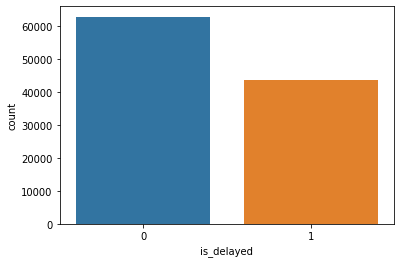

In [826]:
#plt.ylim(0,2000)
#plt.xlim(0,500)
#plt.semilogy(base=10)mont
sns.countplot(data=df1, x="is_delayed")

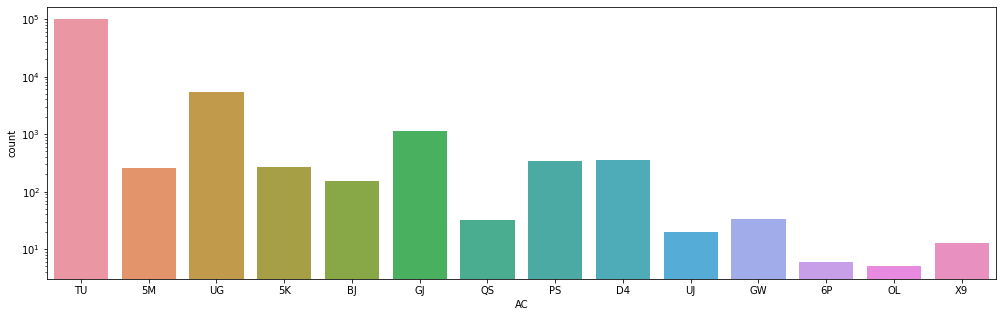

In [827]:
plt.figure(figsize=(17,5))
plt.yscale("log")
sns.countplot(data=df_new, x="AC");

<AxesSubplot:xlabel='STATUS', ylabel='count'>

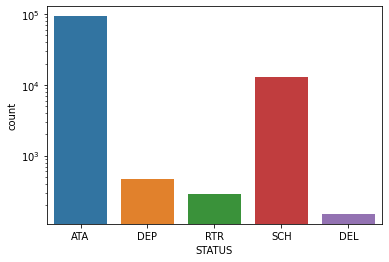

In [828]:
plt.yscale("log")
sns.countplot(data=df_new, x="STATUS")

In [829]:
list1=df_new.columns[1:13].tolist()
list2=df_new.columns[14:26].tolist()
list3=df_new.columns[26:29].tolist()

print(len(list1), len(list2))
print(list1,list2,list3)


12 12
['DEPSTN', 'ARRSTN', 'STATUS', 'AC', 'target', 'city_dep', 'subd_dep', 'country_dep', 'elevation_dep', 'lat_dep', 'lon_dep', 'tz_dep'] ['city_arr', 'subd_arr', 'country_arr', 'elevation_arr', 'lat_arr', 'lon_arr', 'tz_arr', 'sch_duration', 'year', 'dep_hour', 'arr_hour', 'dep_month'] ['arr_month', 'dep_day', 'arr_day']


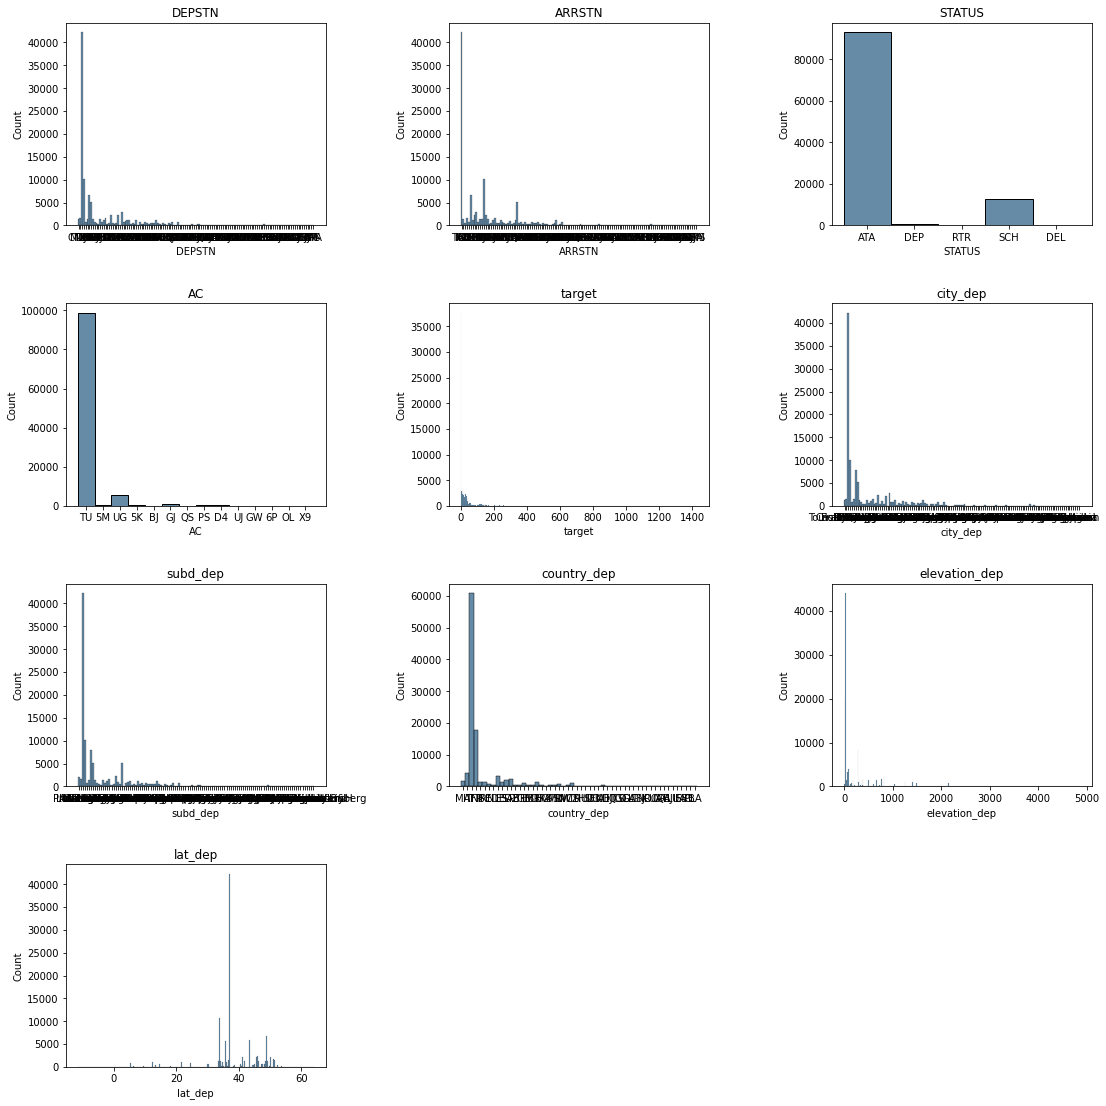

In [830]:
# Outliers
fig,ax = plt.subplots(4,3, figsize=(16,16))
count = 0
for item in df_new[list1].columns.tolist():
    sns.histplot(df_new[item], kde=False, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item)
    
    count += 1
ax.flat[-2].set_visible(False)

ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

In [831]:
# Outliers
#fig,ax = plt.subplots(4,3, figsize=(16,16))
#count = 0
#for item in df_new[list2].columns.tolist():
#    sns.histplot(df_new[item], kde=False, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
#    count += 1
#ax.flat[-2].set_visible(False)

#ax.flat[-1].set_visible(False)
#fig.tight_layout(pad=3)

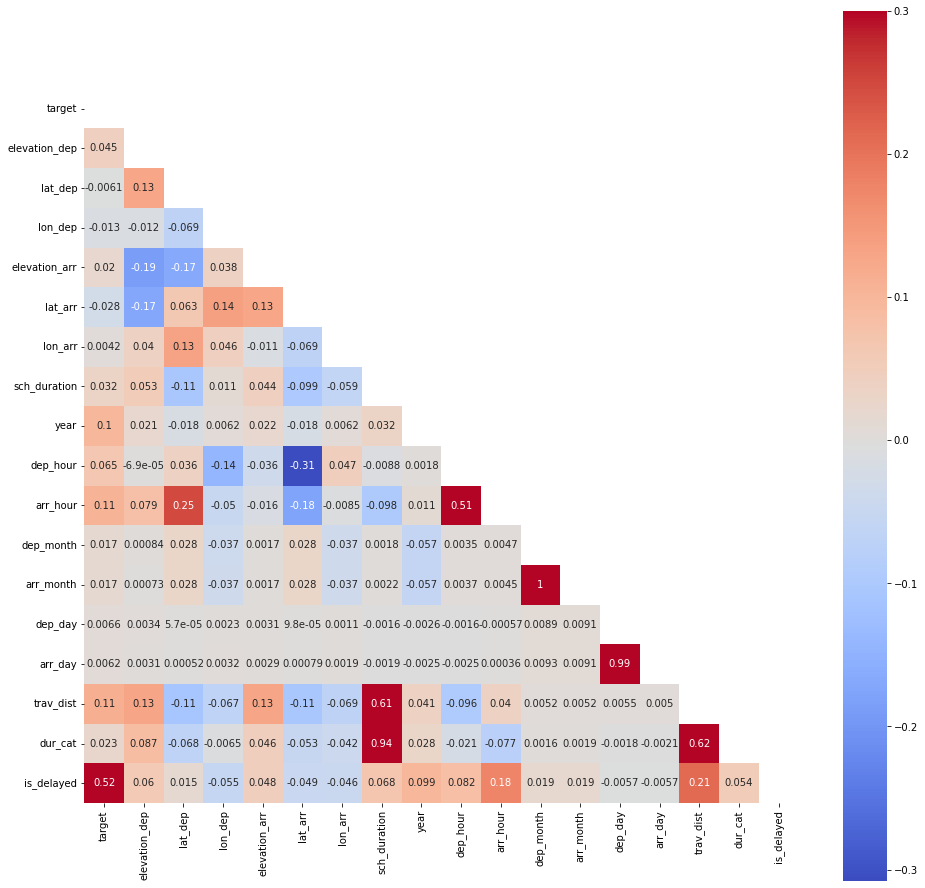

In [832]:
corr = df_new.corr()
#print(corr.round(2))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
cmap = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(16,16))
sns.heatmap(corr, mask=mask, vmax=.3, cmap=cmap, square=True,annot=True);

<AxesSubplot:xlabel='STATUS', ylabel='target'>

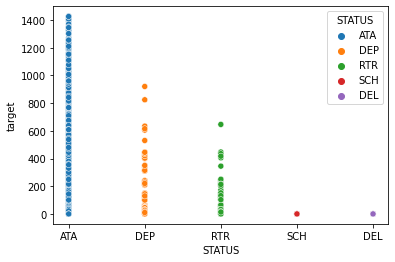

In [833]:
sns.scatterplot(data=df_new, x="STATUS", y="target",hue="STATUS")

<AxesSubplot:xlabel='arr_hour', ylabel='target'>

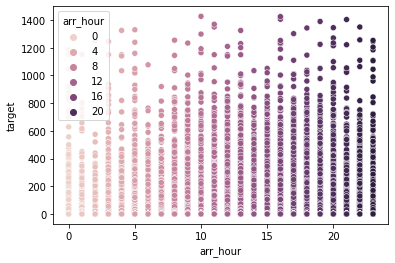

In [834]:
sns.scatterplot(data=df_new, x="arr_hour", y="target",hue="arr_hour")

<AxesSubplot:xlabel='arr_month', ylabel='target'>

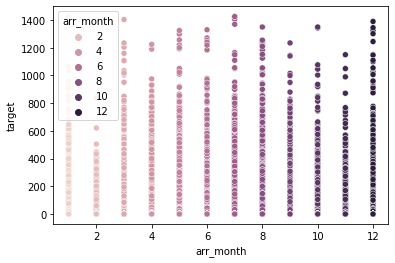

In [835]:
sns.scatterplot(data=df_new, x="arr_month", y="target",hue="arr_month")

<AxesSubplot:xlabel='trav_dist', ylabel='target'>

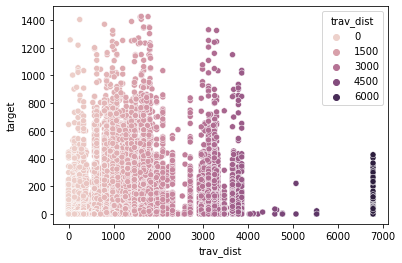

In [836]:
sns.scatterplot(data=df_new, x="trav_dist", y="target",hue="trav_dist")

<AxesSubplot:xlabel='sch_duration', ylabel='target'>

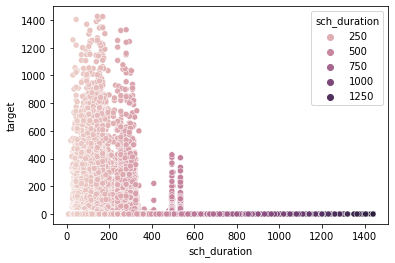

In [837]:
sns.scatterplot(data=df_new, x="sch_duration", y="target",hue="sch_duration")

<AxesSubplot:xlabel='tz_arr', ylabel='Count'>

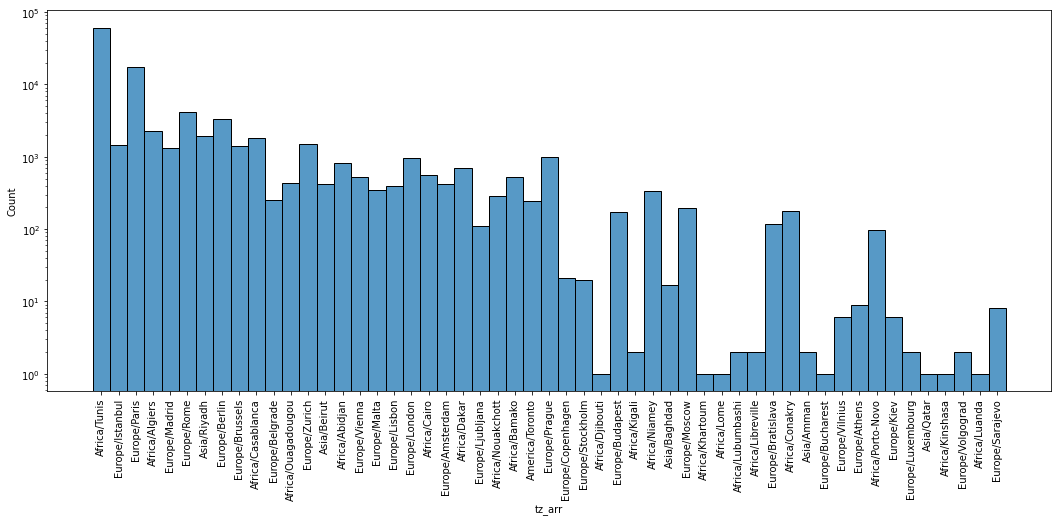

In [838]:
plt.figure(figsize=(18,7))
plt.yscale("log")
plt.xticks(rotation=90)
#sns.histplot(data=df_new, x="city_arr")
sns.histplot(data=df_new, x="tz_arr")

<AxesSubplot:xlabel='city_arr', ylabel='Count'>

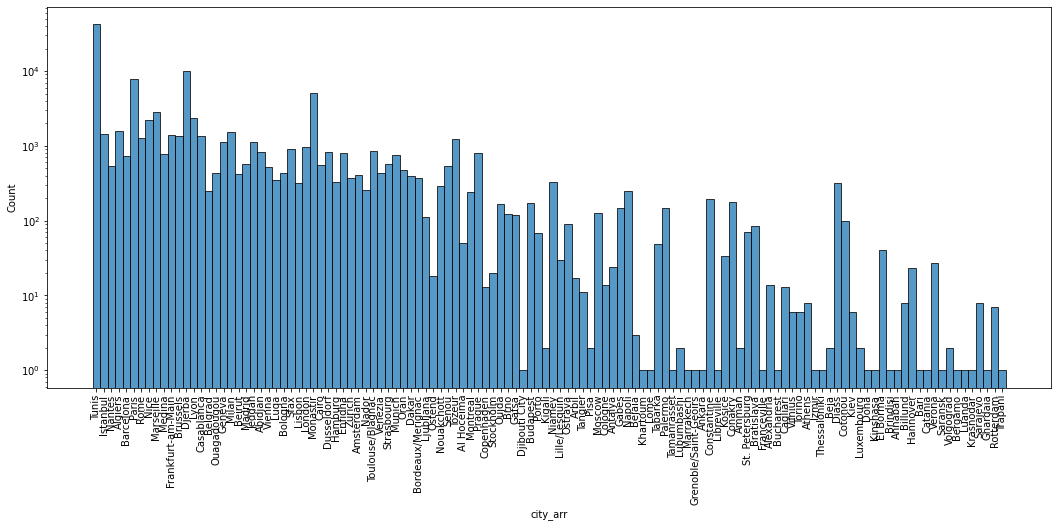

In [864]:
plt.figure(figsize=(18,7))
plt.yscale("log")
plt.xticks(rotation=90)
#sns.histplot(data=df_new, x="city_arr")
sns.histplot(data=df_new, x="city_arr")

<AxesSubplot:xlabel='country_arr', ylabel='Count'>

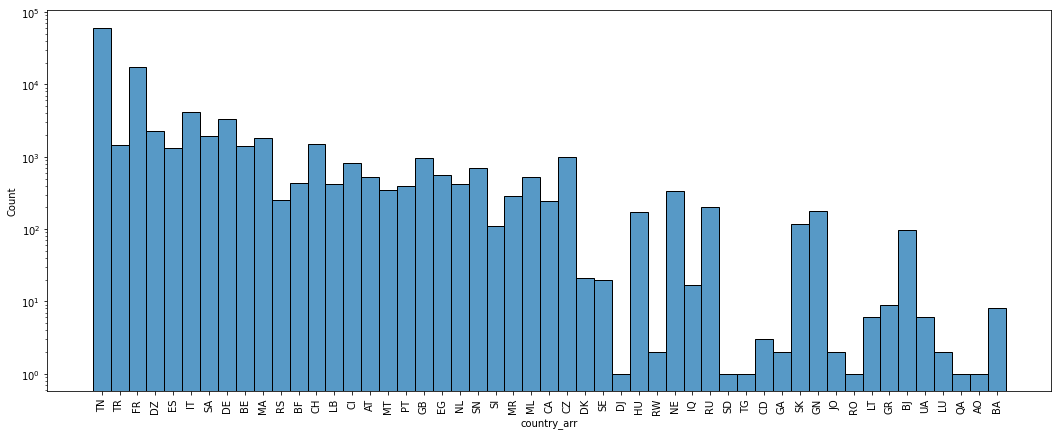

In [869]:
plt.figure(figsize=(18,7))
plt.yscale("log")
plt.xticks(rotation=90)
#sns.histplot(data=df_new, x="city_arr")
sns.histplot(data=df_new, x="country_arr")

# Baseline model (old)

<AxesSubplot:xlabel='target', ylabel='arr_month'>

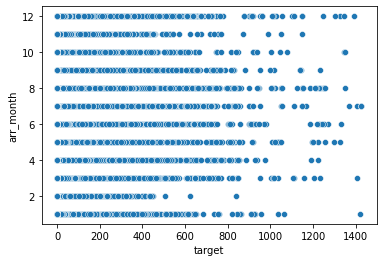

In [840]:
sns.scatterplot(data=df_new, y="arr_month", x="target")

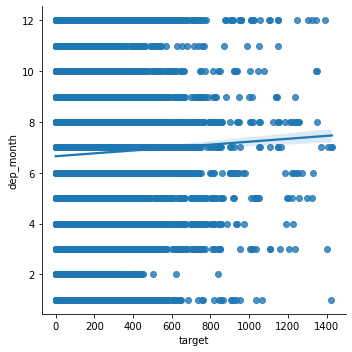

In [841]:
sns.lmplot(data=df_new, x="target", y="dep_month")

In [842]:
df_new.query("dep_month != arr_month")

,FLTID,DEPSTN,ARRSTN,STATUS,AC,target,city_dep,subd_dep,country_dep,elevation_dep,...,year,dep_hour,arr_hour,dep_month,arr_month,dep_day,arr_day,trav_dist,dur_cat,is_delayed
126,TU 0398,ABJ,TUN,ATA,TU,170.0,Abidjan,Lagunes,CI,21.0,...,2016,22,3,6,7,30,1,3784.130856,360,1
315,TU 6058,JED,TUN,ATA,TU,10.0,Jeddah,Makkah,SA,48.0,...,2016,21,2,4,5,30,1,3256.052105,360,0
388,TU 0913,TUN,MED,ATA,TU,23.0,Tunis,Tunis,TN,22.0,...,2016,19,0,2,3,29,1,3118.267129,360,1
1675,TU 0215,IST,TUN,ATA,TU,0.0,Istanbul,Istanbul,TR,325.0,...,2016,23,2,4,5,30,1,1673.053088,240,0
2086,TU 0613,TUN,DKR,ATA,TU,19.0,Tunis,Tunis,TN,22.0,...,2016,19,0,1,2,31,1,3678.974557,360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106389,INT 0000,TUN,TUN,SCH,TU,0.0,Tunis,Tunis,TN,22.0,...,2018,22,2,10,11,31,1,0.000000,240,0
106416,WKL 0000,MIR,MIR,SCH,TU,0.0,Monastir,Al-Munastir,TN,9.0,...,2018,21,0,5,6,31,1,0.000000,240,0
106499,WKL 0000,TUN,TUN,SCH,TU,0.0,Tunis,Tunis,TN,22.0,...,2018,22,1,4,5,30,1,0.000000,240,0
106652,WKL 0000,MIR,MIR,SCH,TU,0.0,Monastir,Al-Munastir,TN,9.0,...,2018,22,1,12,1,31,1,0.000000,240,0


In [843]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#X= df_new[["dep_month"]]
#y= df_new["target"]

#lin = LinearRegression()
#lin.fit(X,y)

#intercept = lin.intercept_
#coef = lin.coef_
#print(intercept.round(2), coef.round(2))

#y_pred = lin.predict(X)
#rms= mean_squared_error(y,y_pred, squared=False)
#print("RMSE: ", rms.round(2))

# Baseline model (new)

In [844]:
base_pred = df_new.sch_duration.to_numpy()*0.05
mean_squared_error(base_pred, df_new.target.to_numpy(), squared=False).round(2)


105.94

# Model Phase I

In [845]:
y= df1["is_delayed"]
X= df1.drop(['target',"is_delayed"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)
data_train, data_test = train_test_split(df1, random_state=RSEED)

In [846]:
from sklearn.model_selection import RandomizedSearchCV

#param_grid = {"max_depth": np.linspace(5,100,50,dtype="int"), "max_leaf_nodes":np.linspace(5,200,50,dtype="int"),"criterion":["gini","entropy"],"min_samples_split":np.linspace(50,100,20,dtype="int"),"max_features":["auto","sqrt","log2"],"oob_score":["True"]}


#estimator = RandomForestClassifier()
#est_CV= RandomizedSearchCV(estimator, param_grid, cv=3, n_jobs=-1, n_iter=10, verbose=5, random_state=RSEED)
#est_CV.fit(X_train,y_train )
#best=est_CV.best_estimator_
#print(best)
#y_pred_cv=best.predict(X_test)
#sco = accuracy_score(y_pred_cv, y_test)
#rec = recall_score(y_pred_cv, y_test)
#print(sco.round(3),rec.round(3))
#rmse2= mean_squared_error(y_test,y_pred_cv, squared=False)
#print("RMSE: ", rmse2.round(2))

In [847]:
#from sklearn.model_selection import GridSearchCV


# Initialize the classifier
#clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# Create the parameters list you wish to tune
#parameters = {'n_estimators':[50, 120],                
#              'learning_rate':[0.1, 0.5, 1.],                         
#              'base_estimator__max_depth' : np.arange(1, 10, 5)              
#             } 

# Make an fbeta_score scoring object
#scorer = make_scorer(fbeta_score,beta=0.5) 


# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
#gs = GridSearchCV(clf, parameters, scoring=scorer, verbose=1, n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
#gs.fit(X_train, y_train)

# TODO: Get the  best estimator
#best_clf = gs.best_estimator_

# TODO: Make predictions using the unoptimized model

#predictions = (clf.fit(X_train, y_train)).predict(X_test)

# TODO: Make predictions using the optimized model
#best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
#print("Unoptimized model\n------")
#print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
#print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
#print("\nOptimized Model\n------")
#print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
#print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
#print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
#print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
#print(best_clf)

In [848]:
#class01 = RandomForestClassifier(max_depth=82, max_features='sqrt', max_leaf_nodes=192,min_samples_split=97, oob_score='True',random_state=RSEED)
class01 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),learning_rate=0.1, n_estimators=120, random_state=RSEED)
class01.fit(X_train,y_train )
#y_pred_cv=estimator.predict(X)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),
                   learning_rate=0.1, n_estimators=120, random_state=42)

In [849]:
y_pred_train=class01.predict(X_train)
y_pred_test=class01.predict(X_test)

sco_train = accuracy_score(y_pred_train, y_train)
rec_train = recall_score(y_pred_train, y_train)
sco_test = accuracy_score(y_pred_test, y_test)
rec_test = recall_score(y_pred_test, y_test)
print(sco_train, sco_test, rec_train, rec_test)

0.7864077669902912 0.737011769997751 0.753238820844183 0.6894928928159816


In [850]:
data_train['is_delayed_pred'] = y_pred_train
data_test['is_delayed_pred'] = y_pred_test

In [851]:
#print(df1.shape)
#df1["pred"]=y_pred_cv
#print(df1.shape)
#df1 = df1.query("pred == 1")
#df1.drop(["pred"],axis=1,inplace=True)
#print(df1.shape)
#X_train, X_test, y_train, y_test = train_test_split(df1.drop('target', axis=1), df1.target, random_state=RSEED)

# Model Phase II

In [852]:

#lin = LinearRegression()
#lin.fit(X_train,y_train)



#y_pred = lin.predict(X_test)
#rms= mean_squared_error(y_test,y_pred, squared=False)
#print("RMSE: ", rms.round(2))


In [853]:
def rmse(y_pred, y_test):
    return np.sqrt(np.sum((y_pred[i]-y_test[i])**2 for i in range(len(y_test)))/len(y_test))

In [854]:
lin_reg1 = LinearRegression()
lin_reg1.fit(data_train.query('is_delayed_pred==1').drop(['target', 'is_delayed_pred'], axis=1), data_train.query('is_delayed_pred==1').target)

LinearRegression()

In [866]:
# calculating feature importance

importance = lin_reg1.coef_
col_list=df1.columns.tolist()
imp_list=[]
for i,v in enumerate(importance):
    imp_list.append(v)

imp_df=pd.DataFrame(list(zip(col_list,imp_list)), columns=["feat","coef"]).sort_values(by="coef", ascending=False)
print(imp_df.head(20))

          feat        coef
79       cd_TR  378.788030
122      ca_SD  148.961608
123      ca_SE  128.319160
9      dur_cat  104.120991
11    stat_DEL   56.311337
20       ac_GW   50.757149
100      ca_GN   48.717151
128      ca_TN   42.045966
118      ca_RS   25.483642
110      ca_ML   21.208226
108      ca_LU   16.802976
127      ca_TG   13.112167
1    trav_dist   10.834315
5     dep_hour    7.985663
120      ca_RW    6.842375
93       ca_DK    3.040880
111      ca_MR    2.733647
113      ca_NE    2.509072
0       target    1.619945
4      dep_day    1.350307


<AxesSubplot:xlabel='target', ylabel='country_dep'>

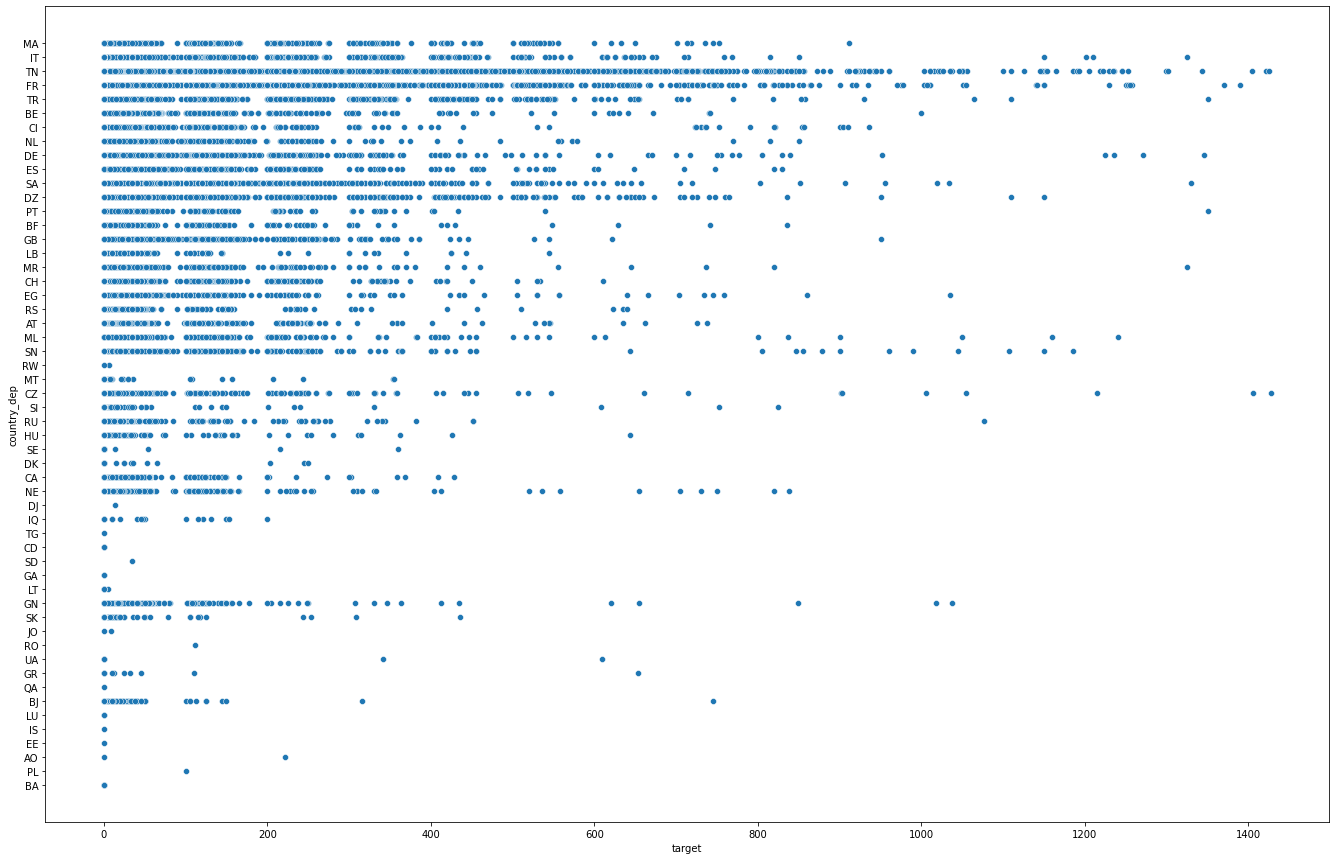

In [894]:
plt.figure(figsize=(23,15))

sns.scatterplot(data=df_new, y="country_dep", x="target")

In [857]:
y_train_pred = lin_reg1.predict(data_train.query('is_delayed_pred==1').drop(['target', 'is_delayed_pred'], axis=1))
y_test_pred = lin_reg1.predict(data_test.query('is_delayed_pred==1').drop(['target', 'is_delayed_pred'], axis=1))

In [858]:
print(rmse(y_train_pred, data_train.query('is_delayed_pred==1').target.to_numpy()))
print(rmse(y_test_pred, data_test.query('is_delayed_pred==1').target.to_numpy()))
print(y_train_pred.shape, data_train.query('is_delayed_pred==1').target.shape)

113.29030912854475
108.5018473920028
(31107,) (31107,)


/var/folders/lb/7b54wx61455bmsb84wphbqvh0000gn/T/ipykernel_35303/3640379205.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sqrt(np.sum((y_pred[i]-y_test[i])**2 for i in range(len(y_test)))/len(y_test))


In [859]:
for j in range(2):

    pred_target_train = []
    counter_train=0
    for i in range(data_train.shape[0]):
        if data_train.is_delayed_pred.to_numpy()[i] == 0:
            pred_target_train.append(j)
        else:
            pred_target_train.append(y_train_pred[counter_train])
            counter_train+=1

    pred_target_test = []
    counter_test=0
    for i in range(data_test.shape[0]):
        if data_test.is_delayed_pred.to_numpy()[i] == 0:
            pred_target_test.append(j)
        else:
            pred_target_test.append(y_test_pred[counter_test])
            counter_test+=1
    
    print(j, rmse(pred_target_train, data_train.target.to_numpy()), rmse(pred_target_test, data_test.target.to_numpy()))

/var/folders/lb/7b54wx61455bmsb84wphbqvh0000gn/T/ipykernel_35303/3640379205.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sqrt(np.sum((y_pred[i]-y_test[i])**2 for i in range(len(y_test)))/len(y_test))


0 88.48213534044714 90.90187126886052
1 88.34214815842046 90.74057514103254


In [860]:
#print(rmse(pred_target_train, data_train.target.to_numpy()), rmse(pred_target_test, data_test.target.to_numpy()))